# Probabilistic Multiple Cracking Model of Brittle-Matrix Composite
The notebooks provides an executable for of the model of multiple-cracking presented in the paper 
[citation]
Elementary studies presented in the paper are reproduced. At the end, an interactive application of the 
present model 

In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import newton
import matplotlib.pylab as plt

In [2]:
Em=25e3  # [MPa] matrix modulus
Ef=180e3  # [MPa] fiber modulus
vf=0.01  # reinforcement ratio
T=12.  # bond intensity
sig_cu=10.0 # [MPa] composite strength
sig_mu=3.0 # [MPa] matrix strength
m=10000 # Weibull shape modulus

## Crack bridge with constant bond

In [3]:
def get_sig_m(z, sig_c):  # matrix stress (*\label{sig_m}*)
    sig_m = np.minimum(z * T * vf / (1 - vf), Em * sig_c / (vf * Ef + (1 - vf) * Em))
    return sig_m

def get_eps_f(z, sig_c):  # reinforcement strain (*\label{sig_f}*)
    sig_m = get_sig_m(z, sig_c)
    eps_f = (sig_c - sig_m * (1 - vf)) / vf / Ef
    return eps_f

## Specimen discretization

In [12]:
def get_z_x(x, XK):  # distance to the closest crack (*\label{get_z_x}*)
    z_grid = np.abs(x[:, np.newaxis] - np.array(XK)[np.newaxis, :])
    return np.amin(z_grid, axis=1)

import warnings # (*\label{error1}*)
warnings.filterwarnings("error", category=RuntimeWarning) # (*\label{error2}*)	
def get_sig_c_z(sig_mu, z, sig_c_pre): 
    # crack initiating load at a material element
    fun = lambda sig_c: sig_mu - get_sig_m(z, sig_c)
    try:  # search for the local crack load level
        return newton(fun, sig_c_pre)
    except (RuntimeWarning, RuntimeError):
        # solution not found (shielded zone) return the ultimate composite strength
        return sig_cu

def get_sig_c_K(z_x, x, sig_c_pre, sig_mu_x):
    # crack initiating loads over the whole specimen
    get_sig_c_x = np.vectorize(get_sig_c_z)
    sig_c_x = get_sig_c_x(sig_mu_x, z_x, sig_c_pre) 
    y_idx = np.argmin(sig_c_x)
    return sig_c_x[y_idx], x[y_idx]

## Crack tracing algorithm

In [38]:
n_x=5000
L_x=500
def get_cracking_history(update_progress=None):
    x = np.linspace(0, L_x, n_x)  # specimen discretization (*\label{discrete}*)
    sig_mu_x = 3.0 * np.random.weibull(m, size=n_x) # matrix strength (*\label{m_strength}*)

    Ec = Em * (1-vf) + Ef*vf # [MPa] mixture rule

    XK = [] # recording the crack postions
    sig_c_K = [0.] # recording the crack initating loads
    eps_c_K = [0.] # recording the composite strains

    idx_0 = np.argmin(sig_mu_x)
    XK.append(x[idx_0])  # position of the first crack
    sig_c_0 = sig_mu_x[idx_0] * Ec / Em
    sig_c_K.append(sig_c_0)
    eps_c_K.append(sig_mu_x[idx_0] / Em)

    while True:
        z_x = get_z_x(x, XK)
        sig_c_k, y_i = get_sig_c_K(z_x, x, sig_c_K[-1], sig_mu_x)
        if sig_c_k == sig_cu: # (*\label{no_crack}*)
            break
        if update_progress:
            update_progress(sig_c_k)
        XK.append(y_i)
        sig_c_K.append(sig_c_k)
        eps_c_K.append(
        np.trapz(get_eps_f(get_z_x(x, XK), sig_c_k), x) / np.amax(x)) # (*\label{imple_avg_strain}*)
        
    sig_c_K.append(sig_cu) # the ultimate state
    eps_c_K.append(np.trapz(get_eps_f(get_z_x(x, XK), sig_cu), x) / np.amax(x))
    if update_progress:
        update_progress(sig_c_k)
    return sig_c_K, eps_c_K

## Examples

In [39]:
sig_c_K, eps_c_K = get_cracking_history() # (*\label{calc_curve}*)
plt.plot(eps_c_K, sig_c_K) # (*\label{show_curve1}*)
plt.show() # (*\label{show_curve2}*)

## Interactive application

<IPython.core.display.Javascript object>


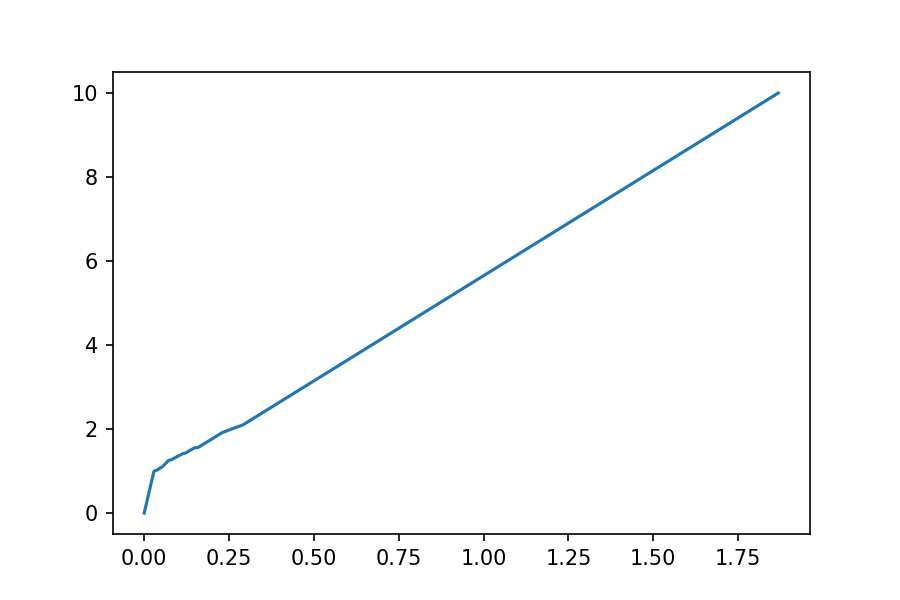

FloatProgress(value=1.0, max=10.0)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Em', max=50.0, min=1.0, ste…

In [43]:
import ipywidgets as ipw
n_steps = 20
margs_sliders = {
    name : ipw.FloatSlider(description=name, value=val, 
                            min=minval, max=maxval, step=(maxval-minval) / n_steps,
                           continuous_update=False)
    for name, val, minval, maxval in [('Em', 1, 1, 50),
                                      ('Ef', 1, 1, 250),
                                      ('vf', 0.1, 0.00001, 0.5),
                                      ('T', 1, 0.0001, 10),
                                      ('sig_cu', 10, 3, 100),
                                     ('sig_mu',3.0, 1, 10),
                                     ('m',100,0.1,100),
                                     ('L_x',500,200,2000)]
}
margs_sliders['n_x'] = ipw.IntSlider(description='n_x', value=20,
                             min=20, max=1000, step=1000/20)
progress = ipw.FloatProgress(min=0, max=1) # instantiate the bar

fig, ax = plt.subplots(1,1,figsize=(6,4))

def update_progress(sig):
    progress.value = sig

def init():
    for key, sl in margs_sliders.items():
        globals()[key] = sl.value
    sig_c_K, eps_c_K = get_cracking_history(update_progress) # (*\label{calc_curve}*)
    progress.max = margs_sliders['sig_cu'].value
    ax.plot(eps_c_K, sig_c_K) # (*\label{show_curve1}*)
        
def update(**mparams):
    for key, val in mparams.items():
        globals()[key] = val
    ax.clear()
    sig_c_K, eps_c_K = get_cracking_history(update_progress) # (*\label{calc_curve}*)
    ax.plot(eps_c_K, sig_c_K) # (*\label{show_curve1}*)

init()
display(progress) # display the bar
ipw.interact(update, **margs_sliders);

In [42]:
nc = 250 / 10
nc

25.0

In [ ]:
u / nc